# Data downloading

In [0]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q /content/drive/My\ Drive/results_max_wt.zip
!unzip -q /content/drive/My\ Drive/wt_cropped_data_720x720.zip
!unzip -q /content/drive/My\ Drive/wt_cropped_gt_720x720.zip
!unzip -q /content/drive/My\ Drive/test_data_720x720.zip

!mkdir ./test_gt
!mv ./test_data_720x720/*_gt.png ./test_gt/

!mv test_data_720x720/ test_data 

!mkdir results_max_wt
!mv /content/content/results_max_wt/* ./results_max_wt/

!rm -r content

!mkdir cropped_data
!mv /content/wt_cropped_data_720x720/wt_cropped_data_720x720/content/cropped_data_720x720/* ./cropped_data

!mkdir cropped_gt
!mv /content/wt_cropped_gt_720x720/content/cropped_gt_720x720/* ./cropped_gt

!rm -r wt_cropped_data_720x720
!rm -r wt_cropped_gt_720x720

In [0]:
!unzip -q /content/drive/My\ Drive/cropped_mask.zip
!unzip -q /content/drive/My\ Drive/test_mask.zip

In [0]:
import os
from collections import Counter

def get_idx_and_num_samples(root):
    data = [int(file.split("_")[0]) for files in os.walk(root) for file in files[2]]
    counter = dict(Counter(data))

    n = [key for key, _ in counter.items()]
    count = [value for _, value in counter.items()]

    return n, count

In [0]:
# get indexes and number of samples for each example

root = '/content/cropped_data'
n, count = get_idx_and_num_samples(root)
root = '/content/test_data'
n_val, count_val = get_idx_and_num_samples(root)

# Generator model

In [0]:
### ================== GENERATOR============================ ####

import torch.nn.functional as F
from torch import nn
import torch
import torch.optim as optim


class DenseBlock(nn.Module):
    """
    DenseNet
    """
    def __init__(self,channels,beta = 0.5):
        super(DenseBlock, self).__init__()
        self.beta = beta
        self.conv_module1 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.conv_module2 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.conv_module3 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.conv_module4 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.last_conv = nn.Conv2d(channels, channels, 3, 1, padding = 1) 

    def forward(self, x): #three layer
        module1_out = self.conv_module1(x)
        module1_out_temp = x + module1_out
        module2_out = self.conv_module2(module1_out_temp)
        module2_out_temp = x + module1_out_temp + module2_out
        module4_out_temp = x + module1_out_temp + module2_out_temp
        last_conv = self.last_conv(module4_out_temp)
        out = x + last_conv * self.beta

        return out


class Generator(nn.Module):
    def __init__(self, in_c, out_c, residual_beta = 0.5):
        """
        in_c : input channels
        out_c: output channels
        """
        super(Generator, self).__init__()
        self.residual_beta = residual_beta

        self.inconv = nn.Sequential(
            nn.Conv2d(in_c, 64, 9, 1, padding=4),
            nn.PReLU()
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(64, beta = residual_beta) for _ in range(2)])
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(128, beta = residual_beta) for _ in range(2)])

        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(256, beta = residual_beta) for _ in range(2)])
        )
        self.bottom = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1 ,padding = 1),
            nn.PReLU(),
            nn.Conv2d(512, 512, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Conv2d(512, 256, 3, 1, padding = 1),
            nn.PReLU()
        )
        self.up1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(256 ,beta = residual_beta) for _ in range(2)]),
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.PReLU()
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(128,beta = residual_beta) for _ in range(2)]),
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.PReLU()
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(64,beta = residual_beta) for _ in range(2)]),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.PReLU()
        )
        self.out = nn.Conv2d(64, out_c, 9, 1, padding = 4)

    def forward(self,x):
        cin = self.inconv(x)
        down1 = self.down1(cin)
        downsample1 = F.avg_pool2d(down1, kernel_size = 2, stride = 2)
        down2 = self.down2(downsample1)
        downsample2 = F.avg_pool2d(down2, kernel_size = 2, stride = 2)
        down3 = self.down3(downsample2)
        downsample3 = F.avg_pool2d(down3, kernel_size = 2, stride = 2)

        bottom = self.bottom(downsample3)

        upsample1 = F.interpolate(bottom, scale_factor = 2)

        cat1 = torch.cat([down3, upsample1], dim = 1)
        up1 = self.up1(cat1)
        upsample2 = F.interpolate(up1, scale_factor = 2)
        cat2 = torch.cat([down2, upsample2],dim = 1)
        up2 = self.up2(cat2)
        upsample3 = F.interpolate(up2, scale_factor = 2)
        cat3 = torch.cat([down1, upsample3], dim = 1)
        up3 = self.up3(cat3)
        out = self.out(up3)
        out = (torch.tanh(out) + 1) / 2

        return out

# Discriminator model

In [0]:
import torch.nn.functional as F
from torch import nn

class DiscriminatorPatch64(nn.Module):
    def __init__(self):
        super(DiscriminatorPatch64, self).__init__()
        self.net1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.net2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.net3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.net4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4)),

            nn.Conv2d(512, 1, kernel_size=1)
        )

    def forward(self, x):
        output1 = self.net1(x)
        output2 = self.net2(output1)
        output3 = self.net3(output2)
        output = self.net4(output3)
        output_shape = (output.size(0), output.size(2), output.size(3))
        final_output = torch.sigmoid(output.view(output_shape))
        
        return final_output, output1, output2, output3

# VGG16 model for perceptual loss

In [0]:
# import torch
# from torchvision import models


# class VGG_OUTPUT(object):

#     def __init__(self, relu1_2, relu2_2, relu3_3, relu4_3):
#         self.__dict__ = locals()


# class VGG16(torch.nn.Module):
#     def __init__(self, requires_grad=False):
#         super(VGG16, self).__init__()
#         vgg_pretrained_features = models.vgg16(pretrained=True).features
#         self.slice1 = torch.nn.Sequential()
#         self.slice2 = torch.nn.Sequential()
#         self.slice3 = torch.nn.Sequential()
#         self.slice4 = torch.nn.Sequential()
#         for x in range(4):
#             self.slice1.add_module(str(x), vgg_pretrained_features[x])
#         for x in range(4, 9):
#             self.slice2.add_module(str(x), vgg_pretrained_features[x])
#         for x in range(9, 16):
#             self.slice3.add_module(str(x), vgg_pretrained_features[x])
#         for x in range(16, 23):
#             self.slice4.add_module(str(x), vgg_pretrained_features[x])
#         if not requires_grad:
#             for param in self.parameters():
#                 param.requires_grad = False

#     def forward(self, X):
#         h = self.slice1(X)
#         h_relu1_2 = h
#         h = self.slice2(h)
#         h_relu2_2 = h
#         h = self.slice3(h)
#         h_relu3_3 = h
#         h = self.slice4(h)
#         h_relu4_3 = h
#         return VGG_OUTPUT(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)

# Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Rotate, VerticalFlip, ShiftScaleRotate
from albumentations.pytorch import ToTensor


class microDataset(Dataset):
    def __init__(self, img_dir, gt_dir, mask_dir, n, count, max_count, transform=None):
        self.count = count
        self.max_count = max_count
        self.n = n
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.mask_dir = mask_dir
        self.img = sorted(next(os.walk(self.img_dir))[2])
        self.gt = sorted(next(os.walk(self.gt_dir))[2])
        self.transform = transform
        self.real_mask = np.array(Image.open("/content/real_mask.png"))
        self.idx = (np.array(Image.open("/content/real_mask.png"))==0)

    def __len__(self):
        return len(self.gt)
    
    def load_img(self,idx,number):
      try:
        img = np.array(Image.open(os.path.join(self.img_dir, f"{self.n[idx]}_{number}.png")))
      except:
        img = np.zeros((720,720,3))
      img[self.idx] = 0
      return img
    
    def load_mask(self,idx,number):
      try:
        mask = np.array(Image.open(os.path.join(self.mask_dir, f"{self.n[idx]}_{number}.png")))[:,:,None]
      except:
        mask = np.zeros((720,720,1))
      mask[self.idx] = 0
      return mask
    
    def __getitem__(self, idx):
        imgs = [self.load_img(idx,number+1) for number in range(self.max_count)] 
        masks = [self.load_mask(idx,number+1) for number in range(self.max_count)]        
        try:
          ground_truth = Image.open(os.path.join(self.gt_dir, f"IFCNN-MAX-{self.n[idx]}.png"))
        except:
          ground_truth = Image.open(os.path.join(self.gt_dir, f"{self.n[idx]}_gt.png"))
        res = []
        if self.transform:
            seed = np.random.randint(666)
            
            # Convert PIL image to numpy array



            gt_np = np.array(ground_truth)
            gt_np[self.idx] = 0
            for i in range(len(imgs)):
              random.seed(seed)
              img = imgs[i]
              aug = self.transform(image=img)
              res.append(aug['image'])
            for i in range(len(masks)):
              random.seed(seed)
              img = masks[i]
              aug = self.transform(image=img)
              res.append(aug['image'])
            random.seed(seed)
            aug = self.transform(image=gt_np)
            res.append(aug['image'])
            random.seed(seed)
            aug = self.transform(image=self.real_mask[:,:,None])
            res.append(aug['image'])
            

        return [torch.cat(res[:2*self.max_count],dim=0),res[-2],res[-1]]

In [0]:
albumentations_pil_transform = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=20, p=0.6),
    ToTensor()
])

albumentations_pil_transform_val = Compose([
    ToTensor()
])

train_dataset = microDataset('/content/cropped_data', '/content/results_max_wt',"/content/cropped_mask", n, count, max(count), transform=albumentations_pil_transform)
# train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True, pin_memory=True)
val_dataset = microDataset('/content/test_data', '/content/test_gt',"/content/test_mask", n_val, count_val, max(count), transform=albumentations_pil_transform_val)
# val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=False, pin_memory=True)

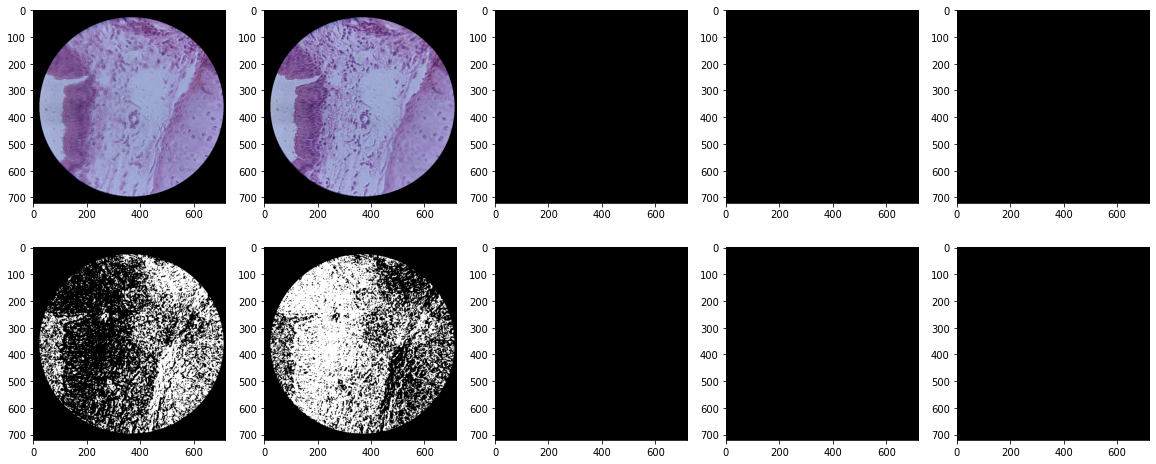

In [0]:
plt.figure(figsize=(20,8))
obj = val_dataset[1]
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(obj[0][i*3:(i+1)*3].numpy().transpose(1,2,0))
for i in range(5):
  plt.subplot(2,5,5+i+1)
  plt.imshow(obj[0][5*3+i].numpy(),cmap='gray')

# Tensorboard

In [0]:
!wget -O utils.py https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
!pip install einops

%load_ext tensorboard
import os
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

--2020-06-02 21:10:08--  https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving drive.google.com (drive.google.com)... 74.125.142.138, 74.125.142.113, 74.125.142.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/37s412eoksnm8qqo18cqsmsn6qppfetf/1591132200000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml [following]
--2020-06-02 21:10:09--  https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/37s412eoksnm8qqo18cqsmsn6qppfetf/1591132200000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)|74.125

<IPython.core.display.Javascript object>

# Training pipeline

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def gan_train(epochs, train_dataset, val_dataset, batch_size, optim_disc, optim_gen, discriminator, generator, scheduler_optim_discriminator, scheduler_optim_generator, exp_name = 'my GAN', flag_gp=False):
    
    writer = SummaryWriter(f'logs/{exp_name}')
    losses_D_hist = []
    losses_G_hist = []

    for epoch in range(epochs):

        # Dataloader
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, pin_memory=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True, pin_memory=True)

        # Train discriminator
        discriminator_running_loss = 0.0
        total = 0
        generator.train()
        for batch_idx, (imgs, target, mask) in enumerate(train_loader):
            mask_torch = Variable(mask.to(device))
            imgs, target = Variable(imgs.to(device)), Variable(target.to(device))

            optim_disc.zero_grad()
            total += batch_size
            fake_data = generator(imgs)
            fake_data *= mask_torch

            disc_loss = nn.BCELoss()(discriminator(target)[0], torch.ones(discriminator(target)[0].shape).cuda()) + nn.BCELoss()(discriminator(fake_data)[0], torch.zeros(discriminator(fake_data)[0].shape).cuda())
            
            discriminator_running_loss += disc_loss.item() * batch_size

            disc_loss.backward()
            optim_disc.step()


            # discriminator loss
            loss_discriminator = discriminator_running_loss / total
            losses_D_hist.append(loss_discriminator)

            # update generator
            optim_gen.zero_grad()
            
            fake_data = generator(imgs)*mask_torch
            out_dis_fake = discriminator(fake_data)
            out_dis_target = discriminator(target)

            mae_loss = 2 * nn.L1Loss()(fake_data, target)

            bce_loss = 0.001 * nn.BCELoss()(out_dis_fake[0], torch.ones(out_dis_fake[0].shape).cuda())

            perc_loss = 0

            for i in range(1, 4):
                perc_loss += nn.MSELoss()(out_dis_fake[i], out_dis_target[i])
              
            gen_loss = mae_loss + bce_loss + perc_loss
           
            losses_G_hist.append(gen_loss.item())

            gen_loss.backward()
            optim_gen.step()

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Discriminator loss', loss_discriminator, global_step = len(losses_D_hist)) 

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss', gen_loss.item(), global_step = len(losses_G_hist))

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss/MAE', mae_loss.item(), global_step = len(losses_G_hist))

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss/BCE', bce_loss.item(), global_step = len(losses_G_hist)) 

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss/PercLoss', 2 * perc_loss.item(), global_step = len(losses_G_hist))    

        # SENDING IMAGES TO TENSORBOARD
        writer.add_images("train/Outputs", fake_data, epoch+1)
        writer.add_images("train/Targets", target, epoch+1)

        generator.eval()
        val_loss = 0
        val_total = 0
        with torch.no_grad():
          for batch_idx, (imgs, target, mask) in enumerate(val_dataloader):
            mask_torch = Variable(mask.to(device))
            imgs, target = Variable(imgs.to(device)), Variable(target.to(device))
            fake_data = generator(imgs)*mask_torch
            val_loss += nn.L1Loss()(fake_data, target).item()*target.size(0)
            val_total += target.size(0)
        writer.add_scalar("Val loss(MAE):",val_loss/val_total,epoch+1)

        # SENDING IMAGES TO TENSORBOARD
        writer.add_images("val/Outputs", fake_data, epoch+1)
        writer.add_images("val/Targets", target, epoch+1)

        scheduler_optim_generator.step()
        scheduler_optim_discriminator.step()

        print(f'epoch : {epoch} | D_loss : {np.round(loss_discriminator, 4)} | G_loss : MAE: {np.round(mae_loss.item(), 4)}, BCE: {np.round(bce_loss.item(), 4)} , PercLoss: {np.round(perc_loss.item(), 4)}')
        

    return losses_D_hist, losses_G_hist

In [0]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.autograd import Variable

### utils
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
exp_name = datetime.now().isoformat(timespec='seconds') + f'FuseGAN'
batch_size = 1
epochs = 200

### models
generator = Generator(20, 3).cuda()
discriminator = DiscriminatorPatch64().cuda()
#perceptual_model = VGG16().cuda()

### optimizers
optim_discriminator = optim.Adam(discriminator.parameters(), lr = 0.4 * 1e-4, betas=(0.0, 0.999))
optim_generator = optim.Adam(generator.parameters(), lr = 0.5 * 1e-4, betas=(0.0, 0.999))

### scheduler:  The learning rates of the generator and discriminator are attenuated after each epoch, lr=lr×0.8
scheduler_optim_discriminator = torch.optim.lr_scheduler.StepLR(optim_discriminator, 1, 0.9)
scheduler_optim_generator = torch.optim.lr_scheduler.StepLR(optim_generator, 1, 0.9)

loss_D_naive, loss_G_naive = gan_train(epochs, train_dataset, val_dataset, batch_size, optim_discriminator, optim_generator, discriminator, generator, scheduler_optim_discriminator, scheduler_optim_generator, exp_name = exp_name, flag_gp=False)

epoch : 0 | D_loss : 1.0096 | G_loss : MAE: 0.1509, BCE: 0.0018 , PercLoss: 1.2601
epoch : 1 | D_loss : 1.0671 | G_loss : MAE: 0.1488, BCE: 0.0009 , PercLoss: 0.7887
epoch : 2 | D_loss : 1.1221 | G_loss : MAE: 0.1027, BCE: 0.0009 , PercLoss: 0.7409
epoch : 3 | D_loss : 1.162 | G_loss : MAE: 0.0579, BCE: 0.0009 , PercLoss: 0.5353
epoch : 4 | D_loss : 1.1799 | G_loss : MAE: 0.1104, BCE: 0.0016 , PercLoss: 1.0597
epoch : 5 | D_loss : 1.1837 | G_loss : MAE: 0.0426, BCE: 0.0005 , PercLoss: 0.5649
epoch : 6 | D_loss : 1.1201 | G_loss : MAE: 0.0433, BCE: 0.0009 , PercLoss: 0.5
epoch : 7 | D_loss : 1.088 | G_loss : MAE: 0.036, BCE: 0.0017 , PercLoss: 0.8918
epoch : 8 | D_loss : 1.0482 | G_loss : MAE: 0.0553, BCE: 0.0012 , PercLoss: 0.5779
epoch : 9 | D_loss : 1.051 | G_loss : MAE: 0.0561, BCE: 0.0008 , PercLoss: 0.3329
epoch : 10 | D_loss : 1.0459 | G_loss : MAE: 0.0218, BCE: 0.0008 , PercLoss: 0.7509
epoch : 11 | D_loss : 1.0232 | G_loss : MAE: 0.0364, BCE: 0.0015 , PercLoss: 0.5199
epoch : 1

KeyboardInterrupt: ignored

In [0]:
torch.save(generator.state_dict(), '/content/drive/My Drive/generator_v1_supervised.pth')

# Model evaluation

In [0]:
!git clone https://github.com/CyrilShch/IFCNN

Cloning into 'IFCNN'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 433 (delta 32), reused 96 (delta 12), pack-reused 310
Receiving objects: 100% (433/433), 62.20 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (43/43), done.


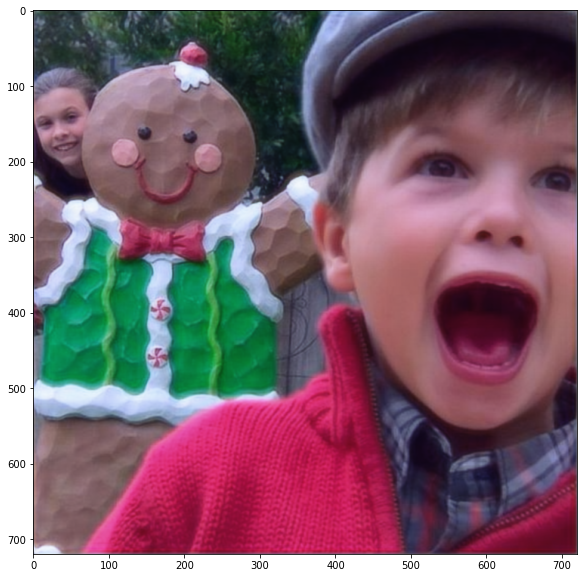

In [0]:
img1_test = Image.open("/content/IFCNN/Code/datasets/CMFDataset/lytro-03-A.jpg")
img2_test = Image.open("/content/IFCNN/Code/datasets/CMFDataset/lytro-03-B.jpg")

img1_test = transforms.Compose([transforms.Resize([720, 720]), transforms.ToTensor()])(img1_test)[None]
img2_test = transforms.Compose([transforms.Resize([720, 720]), transforms.ToTensor()])(img2_test)[None]

test_imgs = torch.cat((img1_test, img2_test), dim=1)
output = generator(test_imgs.cuda())

plt.figure(figsize=[10, 10])
plt.imshow(output.squeeze().detach().cpu().numpy().transpose(1, 2, 0))